In [5]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

The RNN training parts of this notebook are based on the following:

https://medium.com/@claude.feldges/text-classification-with-tf-idf-lstm-bert-a-quantitative-comparison-b8409b556cb3

In [6]:
### functions

sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(y_test, pred, labels=None):

    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [7]:
df_train = pd.read_csv('../../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"['see', 'movies', 'paper', 'tv', 'news', 'some...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"['old', 'know', 'old', 'say', 'reconsider', 's...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"['thats', 'way', 'aha', 'aha', 'like', 'aha', ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"['electric', 'cant', 'see', 'electric', 'got',...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"['cant', 'get', 'satisfaction', 'cant', 'get',...","[cant, get, satisfaction, cant, get, satisfact..."


In [8]:
# word vectors of the following dimensions are available: 50d, 100d, 200d, 300d 
GLOVE_MODELS = {}

for dim in ["300d"]:#["50d", "100d", "200d", "300d"]:
    glove_path = f"../../glove/glove.6B.{dim}.txt"
    glove_word2vec_path = glove_path + '.word2vec'

    if os.path.exists(glove_word2vec_path):
        # load the Stanford GloVe model
        print(f"Loading saved glove word2vec {dim} model")
        GLOVE_MODELS[dim] = KeyedVectors.load_word2vec_format(glove_word2vec_path, binary=False)
    else:
        # load the Stanford GloVe model from txt file, convert to word2vec and save
        print(f"Creating glove word2vec {dim} model")
        glove_model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        glove_model.save_word2vec_format(glove_word2vec_path)
        GLOVE_MODELS[dim] = glove_model

print(GLOVE_MODELS)

Loading saved glove word2vec 300d model
{'300d': <gensim.models.keyedvectors.KeyedVectors object at 0x7fb61692faf0>}


In [9]:
from sklearn.base import BaseEstimator

# create vectorizer that uses glove embeddings
class LyricsVectorizer(BaseEstimator):
    def __init__(self, word_vec_dim="100d", method="mean"):
        self.word_vectors = GLOVE_MODELS[word_vec_dim]
        self.word_vec_dim = word_vec_dim
        self.method = method

    def fit(self, X, y=None):
        return self

    def _transform(self, data):
        # determine the dimensionality of vectors
        vec = np.zeros(self.word_vectors.vector_size)
        
        if type(data) == list:
            #print("Data is tokenized")
            tokenized = True
        elif type(data) == str:
            #print("Data is non-tokenized string")
            tokenized = False
        else:
            print("Not recognized data type")
            return None
        
        if tokenized:
            tokens = data
        else:
            tokens = data.split()
        vecs = []
        for word in tokens:
            try:
                # throws KeyError if word not found
                word_embed = self.word_vectors.get_vector(word)
                vecs.append(word_embed)
            except KeyError:
                pass
        if len(vecs) > 0:
            vecs = np.array(vecs)
            if self.method == "mean":
                vec = vecs.mean(axis=0) # lyrics embedding = mean over all words
            else:
                vec = vecs.sum(axis=0) # lyrics embedding = sum over all words
            # maybe consider concatenation?
        return vec
    
    def transform(self, X):
        return np.concatenate(
            [self._transform(row).reshape(1, -1) for row in X]
            )
    
    def get_params(self, deep=True):
        result = {"word_vec_dim": self.word_vec_dim, "method": self.method}
        return result

In [10]:
from sklearn.preprocessing import LabelBinarizer

# Renaming, Input -> X, Output -> y
#X_tf_train = df_train['lyrics']
#X_tf_test = df_test['lyrics']
X_tf_train = df_train['lemmatized'].apply(' '.join)
X_tf_test = df_test['lemmatized'].apply(' '.join)

# Convert labels into a one-hot vector (length = number of genres)
lab = LabelBinarizer()
lab.fit(df_train['genre'])
y_tf_train = lab.transform(df_train['genre'])
y_tf_test = lab.transform(df_test['genre'])

# Example (you can modify n)
print('Coding of labels into a one-hot vector, e.g.: ')
print(df_train['genre'][0], '->', y_tf_train[0])
print(df_train['genre'][1], ' ->', y_tf_train[1])
print(df_train['genre'][2], '  ->', y_tf_train[2])

Coding of labels into a one-hot vector, e.g.: 
country -> [0 1 0 0 0 0 0 0]
reggae  -> [0 0 0 0 0 0 1 0]
disco   -> [0 0 1 0 0 0 0 0]


In [11]:
corpus = X_tf_train
max_words = 20000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [34]:
max_len = 300

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=0 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print('Example: ',X_tf_train_seq[n,:])

Shape:  (609, 300)
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0   

In [35]:
glove = GLOVE_MODELS["300d"]
corpus_len = len(reverse_voc)
emb_matrix=np.zeros((corpus_len+1, glove.vector_size))

for i in range(corpus_len):
    w = reverse_voc[i+1]
    try:
        # throws KeyError if word not found
        emb_matrix[i+1,:] = glove.get_vector(w)
    except KeyError:
        pass
    
emb_size = emb_matrix.shape[1]
print(emb_matrix.shape)

(7660, 300)


In [40]:
input_ = layers.Input(shape = X_tf_train_seq[0,:].shape, name='input')

# Embedding layer (voc size plus pad token (with index 0), using the pre-trained emb_matrix obtained from glove
x = layers.Embedding(corpus_len+1, emb_size, weights=[emb_matrix], trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(64,dropout=0.2), name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(df_train['genre'].nunique(), activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          2298000   
                                                                 
 bidirectional-lstm (Bidirec  (None, 128)              186880    
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 classification (Dense)      (None, 8)                 520       
                                                           

In [42]:
start_time = datetime.now()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=16, shuffle=True, epochs=30, callbacks=[callback], validation_data=(X_tf_test_seq, y_tf_test))
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/30
39/39 [==============================] - 8s 141ms/step - loss: 2.0259 - accuracy: 0.1773 - val_loss: 1.9396 - val_accuracy: 0.2026
Epoch 2/30
39/39 [==============================] - 5s 127ms/step - loss: 1.8215 - accuracy: 0.3350 - val_loss: 1.9024 - val_accuracy: 0.2353
Epoch 3/30
39/39 [==============================] - 5s 121ms/step - loss: 1.6660 - accuracy: 0.3941 - val_loss: 1.8230 - val_accuracy: 0.3203
Epoch 4/30
39/39 [==============================] - 5s 130ms/step - loss: 1.5072 - accuracy: 0.4598 - val_loss: 1.7670 - val_accuracy: 0.3399
Epoch 5/30
39/39 [==============================] - 6s 149ms/step - loss: 1.3489 - accuracy: 0.5255 - val_loss: 1.7710 - val_accuracy: 0.4052
Epoch 6/30
39/39 [==============================] - 6s 146ms/step - loss: 1.1277 - accuracy: 0.6305 - val_loss: 1.7173 - val_accuracy: 0.4379
Epoch 7/30
39/39 [==============================] - 6s 151ms/step - loss: 1.0039 - accuracy: 0.6502 - val_loss: 1.7350 - val_accuracy: 0.3791
Epoch 


Accuracy Training data:  98.69%
Accuracy Test data:      48.37%
Training time: 174.0 sec



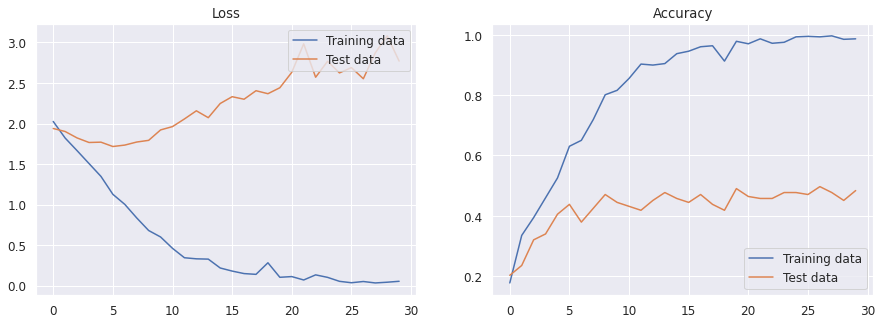

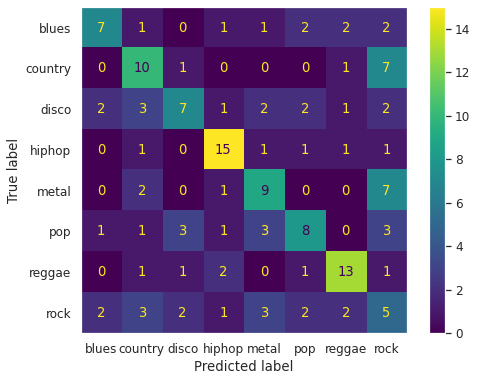

Accuracy  = 0.48366013071895425
F1 score  = 0.4870034203170614
Precision = 0.5001796678267266
Recall    = 0.48366013071895425


In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="lower right")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data:  {:.2%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data:      {:.2%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f} sec'.format(training_time_rnn))
print("")

pred_prob = model.predict(X_tf_test_seq)
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)


Accuracy Training data:  96.72%
Accuracy Test data:      41.83%
Training time: 117.7 sec



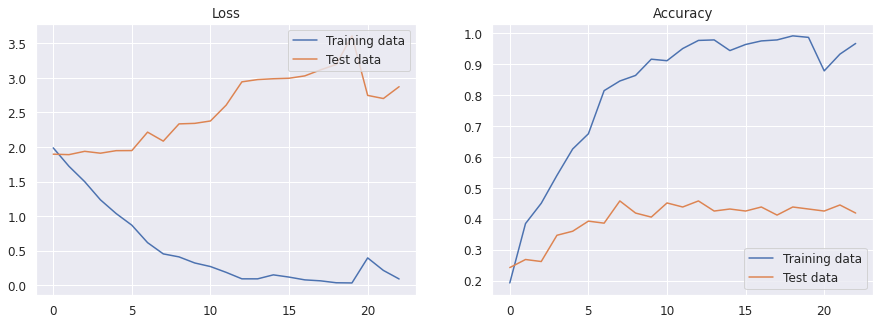

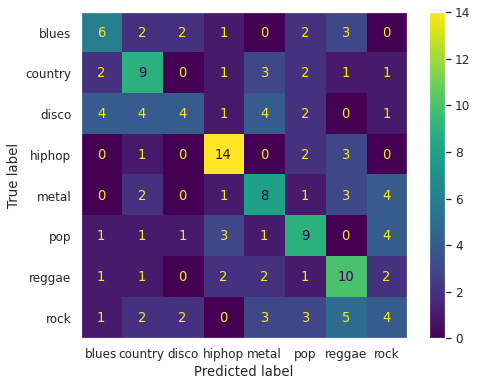

Accuracy  = 0.41830065359477125
F1 score  = 0.4073708865832118
Precision = 0.4134342655229271
Recall    = 0.41830065359477125


In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training data')
ax[0].plot(history.history['val_loss'], label='Test data')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training data')
ax[1].plot(history.history['val_accuracy'], label='Test data')
ax[1].legend(loc="lower right")

print("")
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data:  {:.2%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data:      {:.2%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f} sec'.format(training_time_rnn))
print("")

pred_prob = model.predict(X_tf_test_seq)
pred = np.argmax(pred_prob, axis=1)
pred = lab.classes_[pred].tolist()
evaluate_classifier(df_test['genre'], pred, lab.classes_)